scikit-learn, Machine Learning in Python
- Simple and efficient tools for predictive data analysis
- Accessible to everybody, and reusable in various contexts
- Built on NumPy, SciPy, and matplotlib
- Open source, commercially usable - BSD license


Check also: 
- https://scikit-learn.org/stable/index.html
- https://scikit-learn.org/stable/modules/tree.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
np.random.seed(42)

Solution of the previous `Hands on`

In [2]:
def clean(normalize=True):
    df = pd.read_csv("datasets/housing.csv", delimiter=",")
    
    num_df = df.drop(columns=["ocean_proximity", "median_house_value"])

    # Filling in (i.e., impute) missing values with the median value 
    num_df["total_bedrooms"] = num_df["total_bedrooms"].fillna(num_df["total_bedrooms"].median())

    # Add a new column: population_per_household = population / households
    num_df["population_per_household"] = num_df["population"] / num_df["households"]

    # Add a new column: rooms_per_household = total_rooms / households
    num_df["rooms_per_household"] = num_df["total_rooms"] / num_df["households"]

    # Add a new column: bedrooms_per_room = total_bedrooms / total_rooms
    num_df["bedrooms_per_room"] = num_df["total_bedrooms"] / num_df["total_rooms"]

    if normalize:
        # Apply standardization to all the numeric columns
        num_df = (num_df - num_df.mean()) / num_df.std()

    # One hot encode `ocean_proximity` since it is a categorical attribute 
    cat_df = pd.get_dummies(df["ocean_proximity"], prefix='ocean_proximity')

    return pd.concat([num_df, cat_df, df[["median_house_value"]]], axis=1) # do not change this line

df = clean()

For a supervised learning problem we need:
- input data along with labels
- split data between test and training set

In [3]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

df_train, df_test = split_train_test(df, 0.2)
X_train = df_train.drop(columns=["median_house_value"]).to_numpy()
X_test  = df_test.drop(columns=["median_house_value"]).to_numpy()
y_train = df_train["median_house_value"].to_numpy()
y_test  = df_test["median_house_value"].to_numpy()

In [4]:
from sklearn.model_selection import train_test_split
y = df["median_house_value"] # labels
X = df.drop(columns=["median_house_value"]) # input data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,population_per_household,rooms_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
5088,0.643716,-0.773361,-0.765917,-0.803424,-0.533722,-0.617660,-0.582062,-1.521075,-0.043300,-0.905868,2.156065,1,0,0,0,0
17096,-1.327803,0.855889,0.346470,0.003317,-0.173677,-0.362464,-0.189731,0.185559,-0.066782,0.307455,-0.586009,0,0,0,0,1
5617,0.653698,-0.862314,1.061575,-0.675538,-0.650558,-0.336856,-0.676222,-0.169422,0.121441,-0.245505,0.205376,1,0,0,0,0
20060,0.154579,0.111491,-0.368636,-0.479353,-0.350123,0.230050,-0.333586,-1.170516,0.140728,-0.466744,0.482602,0,1,0,0,0
895,-1.193041,0.893343,-1.163197,1.132297,1.597935,1.159000,1.591454,0.063284,-0.057725,-0.331705,0.346285,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.803433,-0.866996,0.505382,-0.598530,-0.800776,-0.677706,-0.738995,1.315560,-0.003697,0.282936,-0.960430,1,0,0,0,0
11964,1.067966,-0.754634,0.346470,0.205461,0.079070,0.289213,-0.132189,-0.431973,0.080259,0.581850,-0.443985,0,1,0,0,0
5390,0.593804,-0.749952,0.584838,-0.245123,0.076685,0.291863,0.071824,-0.492820,0.025170,-0.582935,0.874037,1,0,0,0,0
860,-1.193041,0.912070,-1.083741,0.430524,0.143449,0.310406,0.155521,0.973001,0.010421,0.390575,-0.717278,1,0,0,0,0


In [6]:
y_train

5088     121400.0
17096    363700.0
5617     205600.0
20060     47600.0
895      236000.0
           ...   
11284    229200.0
11964     97800.0
5390     222100.0
860      283500.0
15795    325000.0
Name: median_house_value, Length: 13828, dtype: float64

Apply linear regression to forecast housing values

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression() # initialize the model
lin_reg.fit(X_train, y_train) # train it
housing_predictions = lin_reg.predict(X_test) # predict the cost of houses in the test set
lin_mse = mean_squared_error(y_test, housing_predictions) # check the error
lin_rmse = np.sqrt(lin_mse)
lin_rmse # print it

70532.346029265

This is better than nothing, but clearly not a great score: most districts’ `median_housing_values` range between 120K USD and  265K USD, so a typical prediction error of ~70K USD is not very satisfying. This is an example of a model underfitting the training
data.

In [8]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42) # initialize the model
forest_reg.fit(X_train, y_train) # train it
housing_predictions = forest_reg.predict(X_test) # predict the cost of houses in the test set
forest_rmse = mean_squared_error(y_test, housing_predictions, squared=True) # check the error
forest_rmse = np.sqrt(forest_rmse)
forest_rmse

50155.05753085368

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = clean(False)
df["median_house_value"] = pd.cut(df["median_house_value"], 3, labels=["low", "medium", "high"])

y = df["median_house_value"] # labels
# X = df.drop(columns=["median_house_value"]) # input data
X = df[["latitude", "longitude", "median_income"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="entropy", random_state=42, min_samples_leaf=500) # initialize the model
clf = clf.fit(X_train, y_train) # train it
housing_predictions = clf.predict(X_test) # predict the cost of houses in the test set
accuracy = accuracy_score(y_test, housing_predictions) # check the error
accuracy

0.7116852613035819

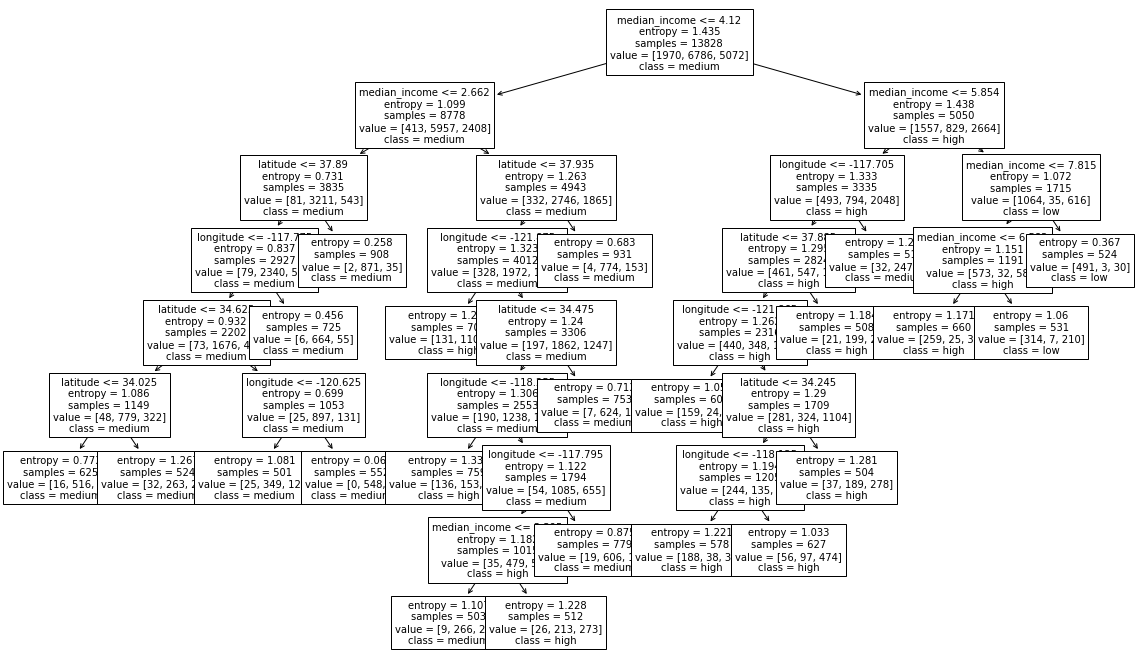

In [10]:
plt.figure(figsize=(20,12))
tree.plot_tree(clf, fontsize=10, feature_names = X_train.columns, class_names=["low", "medium", "high"])
plt.show()